# Load packages and defaults

In [1]:
import os
from typing import Literal

# Move two levels up work from project level, not location of analysis file
os.chdir('../..')
print('Working dir:', os.getcwd())

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import seaborn as sns

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

from scipy import stats
from scipy import optimize
from scipy.interpolate import interpn
from scipy import integrate

from Analyses.SDC_miglioreModels.tools import *
from Analyses.SDC_miglioreModels import loader
import Functions.globalFunctions.ExtracellularField as EcF
from Analyses.functionsAnalysis import *


%matplotlib inline
recollect = False

# Figure for paper
font = {'family': 'helvetica',
        'size': 10}
mpl.rc('font', **font)
colors_crest = np.array(sns.color_palette("crest", n_colors=10))
colors_crest = colors_crest[[0,2,5,8],:]
cmap_tab20 = np.array(mpl.cm.get_cmap('tab20').colors)

colors = np.array(sns.color_palette("crest", n_colors=10))
colors = colors[[0, 2, 5, 8], :]
crestcmap_pvalue = LinearSegmentedColormap.from_list('my_cmap', colors, N=colors.shape[0])
boundaries = [0.001, 0.01, 0.05, 1.0]
boundnorm_pvalue = mpl.cm.colors.BoundaryNorm(
    boundaries, len(boundaries), extend='min')

def myfun(x, y): return list(mpl.colors.to_rgb(x))+[y]

colorkeyval = {'soma': myfun('tab:red', 1), 'axon': myfun('tomato', 1), 'apic': myfun('seagreen', 1),
                'basaldend': myfun('navy', 1), 'alldend': myfun('skyblue',1), 'allsec': myfun('tab:blue', 1),
                'pyr_1': list(cmap_tab20[2,:])+[1],'pyr_2': list(cmap_tab20[3,:])+[1],
                'pyr_3': list(cmap_tab20[4,:])+[1],'pyr_4': list(cmap_tab20[5,:])+[1],
                'bc_1': list(cmap_tab20[8,:])+[1],'bc_2': list(cmap_tab20[9,:])+[1], 'unclassified': [0, 0, 0]}
stylekeyval = {'pyr_1': '-', 'pyr_2': '--', 'bc_1': ':', 'bc_2': '-.'}

surfaces = {'soma': {'pyr_1': 699.46, 'pyr_2': 417.85, 'bc_1': 778.12, 'bc_2': 1375.16},
            'axon': {'pyr_1': 1640.70, 'pyr_2': 1051.43, 'bc_1': 106424.01, 'bc_2': 25256.23},
            'basaldend': {'pyr_1': 5930.95, 'pyr_2': 10670.46, 'bc_1': np.nan, 'bc_2': np.nan},
            'apic': {'pyr_1': 14786.82, 'pyr_2': 13631.61, 'bc_1': np.nan, 'bc_2': np.nan},
            'alldend': {'pyr_1': 20717.77, 'pyr_2': 24170.88, 'bc_1': 21827.34, 'bc_2': 21949.07},
            'allsec': {'pyr_1': 23057.93, 'pyr_2': 25640.17, 'bc_1': 129029.47, 'bc_2': 48580.46}}


Working dir: d:\Users\rschoete\Documents\Optogenetics\OptogeneticExcitability\Code


# Loading raw data
stored in master_df

unique_values_columns_master contains all unique values for each column

MiglioreModels

In [2]:
# Load data
filepath = './Results/SDC/SDC_constI_miglioreModels'
drop_columns = ['opsinmech', 'distribution', 'distribution_method',
                'theta_0', 'psi_0', 'phi_0', 'seed', 'celsius', 'dt', 'field']

# list parameters of interest
cell_init_options = ['phi_0', 'theta_0',
                     'psi_0', 'neurontemplate', 'morphology', "miglioreModel", 'hoc_file']
settings_options = ['seed', 'celsius', 'dt']
opsin_options = ['Gmax', 'distribution', 'opsinmech',
                 'distribution_method', 'opsinlocations']
field_options = ['field', 'nPulse']
result = ['amp', 'sR', 'ichr2', 'gchr2', 'dur']
all_columns = result+field_options+opsin_options + \
    cell_init_options+settings_options

# opsinlocations to single word
opsinLocation_map = loader.opsinLocation_map
master_df = loader.load_data_df(filepath=filepath, filename='all_data(2).csv', recollect=recollect, result=result, all_columns=all_columns, cell_init_options=cell_init_options,
                                settings_options=settings_options, opsin_options=opsin_options, field_options=field_options, fill_missing_xyzpositions=True, save_recollect=True, savename=None)
master_df = master_df[~master_df['neurontemplate'].str.contains('bACnoljp')]
master_df['amp'] = master_df['amp']/1000  # convert W/m2 -> mW/mm2
master_df['TAC'] = -master_df['ichr2']/master_df['dur'] * \
    1e-5  # convert to uA (ichr2: mA/cm2*um2)
master_df['Gmax'] = np.round(master_df['Gmax'], 4)
master_df['dur'] = np.round(master_df['dur'], 4)
for x in ['amp', 'Gmax', 'TAC', 'dur']:
    master_df[x+'_log10'] = np.round(np.log10(master_df[x]), 4)
master_df = master_df.drop(drop_columns, axis=1)
master_df['neurontemplate'] = master_df['neurontemplate'].replace(
    {'CA1_PC_cAC_sig5': 'pyr_1', 'CA1_PC_cAC_sig6': 'pyr_2', 'cNACnoljp1': 'bc_1', 'cNACnoljp2': 'bc_2'})
for x in ['morphology', 'miglioreModel', 'hoc_file']:
    if x in master_df.columns:
        master_df[x] = master_df[x].replace(
            {np.nan: 'default'})

print('!!!!!!!!!!!!!!excluding Gmax <0.1!!!!!!!')
master_df = master_df[master_df['Gmax'] >= 0.099]

all_columns = master_df.columns
all_settings_columns = [x for x in all_columns if (not x in drop_columns) and (
    not any([y in x for y in result[:-1]+['TAC']]))]
unique_values_columns_master = {
    key: master_df[key].unique() for key in all_columns}
for x in ['amp', 'Gmax', 'TAC', 'dur']:
    unique_values_columns_master[x] = np.sort(unique_values_columns_master[x])
    unique_values_columns_master[x+'_log10'] = np.sort(
        unique_values_columns_master[x+'_log10'])

print('all coluumn names:\n\t', all_columns.to_numpy())
print('all settings:\n\t', all_settings_columns)
print('Total number of entries:\n\t', len(master_df))
for k in all_settings_columns:
    print(f'unique entries {k}:\n\t', len(
        unique_values_columns_master[k]), ': ', unique_values_columns_master[k])
    if 'Gmax' in k:
        print('2 sets: ', np.unique(master_df.loc[master_df['opsinlocations'] == 'soma', 'Gmax']), '\n ', np.unique(
            master_df.loc[master_df['opsinlocations'] == 'allsec', 'Gmax']))
master_df.describe()

!!!!!!!!!!!!!!excluding Gmax <0.1!!!!!!!
all coluumn names:
	 ['amp' 'sR' 'ichr2' 'gchr2' 'dur' 'nPulse' 'Gmax' 'opsinlocations'
 'neurontemplate' 'morphology' 'miglioreModel' 'hoc_file' 'TAC'
 'amp_log10' 'Gmax_log10' 'TAC_log10' 'dur_log10']
all settings:
	 ['dur', 'nPulse', 'Gmax', 'opsinlocations', 'neurontemplate', 'morphology', 'miglioreModel', 'hoc_file', 'Gmax_log10', 'dur_log10']
Total number of entries:
	 2424
unique entries dur:
	 3 :  [  1  10 100]
unique entries nPulse:
	 1 :  [1]
unique entries Gmax:
	 2 :  [ 1 10]
2 sets:  [ 1 10] 
  [ 1 10]
unique entries opsinlocations:
	 6 :  ['alldend' 'allsec' 'apic' 'axon' 'basaldend' 'soma']
unique entries neurontemplate:
	 6 :  ['pyr_1' 'pyr_2' 'CA1_PC_migliore' 'bc_1' 'bc_2' 'cNACnoljp_migliore']
unique entries morphology:
	 1 :  ['default']
unique entries miglioreModel:
	 27 :  ['default' 'CA1_pyr_cACpyr_mpg141017_a1-2_idC_20190328143405'
 'CA1_pyr_cACpyr_mpg141208_B_idA_20190328144006'
 'CA1_pyr_cACpyr_mpg141209_A_idA_20190328

,amp,sR,ichr2,gchr2,dur,nPulse,Gmax,TAC,amp_log10,Gmax_log10,TAC_log10,dur_log10
count,2183.000000,2183.000000,2424.000000,2424.000000,2424.000000,2424.0,2424.000000,2424.000000,2183.000000,2424.000000,2424.000000,2424.000000
mean,0.779561,1.000916,-5081.658867,2.372213,37.000000,1.0,5.500000,0.010478,-1.404573,0.500000,-2.577215,1.000000
std,19.139854,0.030261,9711.012195,6.217062,44.708216,0.0,4.500929,0.028531,0.841243,0.500103,0.703592,0.816665
min,0.000201,1.000000,-147191.710400,-28.563000,1.000000,1.0,1.000000,0.000071,-3.696600,0.000000,-4.148500,0.000000
25%,0.007429,1.000000,-4897.824800,0.199725,1.000000,1.0,1.000000,0.000646,-2.129100,0.000000,-3.189900,0.000000
50%,0.046910,1.000000,-2346.580950,0.602300,10.000000,1.0,5.500000,0.001702,-1.328700,0.500000,-2.769000,1.000000
75%,0.170313,1.000000,-1259.646900,1.932800,100.000000,1.0,10.000000,0.011079,-0.768800,1.000000,-1.955475,2.000000
max,634.375000,2.000000,-157.664200,70.091900,100.000000,1.0,10.000000,0.405454,2.802300,1.000000,-0.392100,2.000000


In [3]:
# test selector
myselection = {key: unique_values_columns_master[key][0]
               for key in all_settings_columns if not '_log10' in key}
myselection['dur'] = 100
myselection['Gmax'] = 1
intm_df = master_df[selection_generator(
    master_df, unique_values_columns_master, verbose=False, **myselection)].reset_index(drop=True)
intm_df.head(len(intm_df))

,amp,sR,ichr2,gchr2,dur,nPulse,Gmax,opsinlocations,neurontemplate,morphology,miglioreModel,hoc_file,TAC,amp_log10,Gmax_log10,TAC_log10,dur_log10
0,0.075232,1.0,-4341.4173,1.3045,100,1,1,alldend,pyr_1,default,default,default,0.000434,-1.1236,0.0,-3.3624,2.0


In [4]:
master_df["nt_mg_hf"] = master_df["neurontemplate"] + \
    master_df["miglioreModel"]+master_df["hoc_file"]
unique_cell_mapper = {}
int_counter = -1
pyr_counter = -1
for x in master_df["nt_mg_hf"].unique():
    if not 'pyr' in x:
        int_counter += 1
        unique_cell_mapper[x] = f"int_{int_counter}"
    else:
        pyr_counter += 1
        unique_cell_mapper[x] = f"pyr_{pyr_counter}"
master_df['cell_id'] = master_df["nt_mg_hf"].map(unique_cell_mapper)
master_df['cell_type'] = master_df['cell_id'].str.split('_').str[0]
master_df['ct_ol'] = master_df['cell_type'] + '_' + master_df['opsinlocations']
master_df["cell_id"].unique()

array(['pyr_0', 'pyr_1', 'pyr_2', 'pyr_3', 'pyr_4', 'pyr_5', 'pyr_6',
       'pyr_7', 'pyr_8', 'pyr_9', 'pyr_10', 'pyr_11', 'pyr_12', 'pyr_13',
       'pyr_14', 'pyr_15', 'pyr_16', 'pyr_17', 'pyr_18', 'pyr_19',
       'pyr_20', 'pyr_21', 'pyr_22', 'pyr_23', 'pyr_24', 'pyr_25',
       'pyr_26', 'pyr_27', 'pyr_28', 'pyr_29', 'pyr_30', 'pyr_31',
       'pyr_32', 'pyr_33', 'pyr_34', 'pyr_35', 'pyr_36', 'pyr_37',
       'pyr_38', 'pyr_39', 'int_0', 'int_1', 'int_2', 'int_3', 'int_4',
       'int_5', 'int_6', 'int_7', 'int_8', 'int_9', 'int_10', 'int_11',
       'int_12', 'int_13', 'int_14', 'int_15', 'int_16', 'int_17',
       'int_18', 'int_19', 'int_20', 'int_21', 'int_22', 'int_23',
       'int_24', 'int_25', 'int_26', 'int_27', 'int_28', 'int_29',
       'int_30', 'int_31', 'int_32', 'int_33', 'int_34', 'int_35',
       'int_36', 'int_37', 'int_38', 'int_39', 'int_40'], dtype=object)

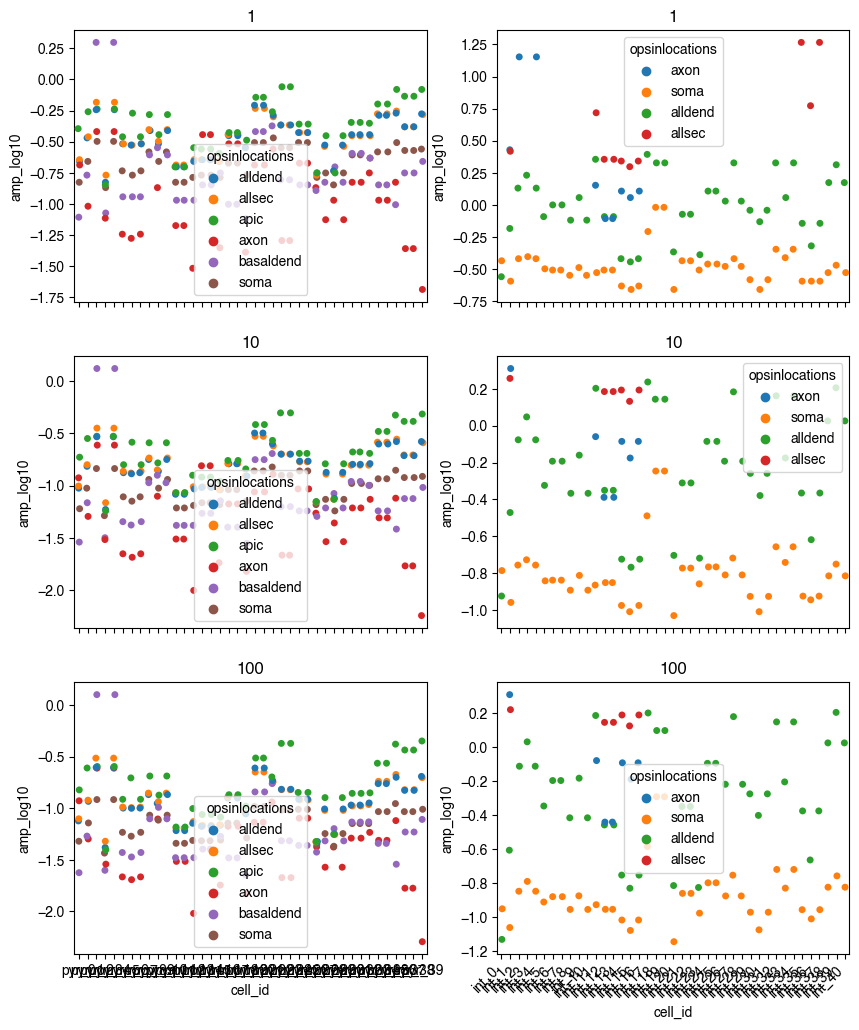

In [5]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12), sharex='col')
for x, axrow in zip(unique_values_columns_master['dur'], axs):
    for mytype, ax in zip(["pyr", 'int'], axrow):
        idx = (master_df['Gmax'] == 1) & (master_df['dur'] == x) & (
            np.array(master_df['cell_id'].str.contains(mytype)))
        sns.stripplot(data=master_df[idx], x='cell_id',
                      y='amp_log10', hue='opsinlocations', ax=ax)
        ax.set_title(x)
plt.draw()
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
print()

In [6]:
idx = (master_df['Gmax'] == 1) & (master_df['dur'] == x) & (
    np.array(master_df['cell_id'].str.contains('pyr')))
idx2 = idx & (master_df['miglioreModel'] == 'default')
master_df[idx2]

,amp,sR,ichr2,gchr2,dur,nPulse,Gmax,opsinlocations,neurontemplate,morphology,...,hoc_file,TAC,amp_log10,Gmax_log10,TAC_log10,dur_log10,nt_mg_hf,cell_id,cell_type,ct_ol
50,0.075232,1.0,-4341.4173,1.30450,100,1,1,alldend,pyr_1,default,...,default,0.000434,-1.1236,0.0,-3.3624,2.0,pyr_1defaultdefault,pyr_0,pyr,pyr_alldend
56,0.078910,1.0,-4593.7805,1.72520,100,1,1,allsec,pyr_1,default,...,default,0.000459,-1.1029,0.0,-3.3378,2.0,pyr_1defaultdefault,pyr_0,pyr,pyr_allsec
62,0.150458,1.0,-5965.0252,1.72900,100,1,1,apic,pyr_1,default,...,default,0.000597,-0.8226,0.0,-3.2244,2.0,pyr_1defaultdefault,pyr_0,pyr,pyr_apic
68,0.117951,1.0,-5873.7176,10.70240,100,1,1,axon,pyr_1,default,...,default,0.000587,-0.9283,0.0,-3.2311,2.0,pyr_1defaultdefault,pyr_0,pyr,pyr_axon
74,0.023668,1.0,-2018.6773,0.62970,100,1,1,basaldend,pyr_1,default,...,default,0.000202,-1.6258,0.0,-3.6949,2.0,pyr_1defaultdefault,pyr_0,pyr,pyr_basaldend
80,0.047795,1.0,-3105.6471,0.06785,100,1,1,soma,pyr_1,default,...,default,0.000311,-1.3206,0.0,-3.5078,2.0,pyr_1defaultdefault,pyr_0,pyr,pyr_soma
86,0.116506,1.0,-5263.4243,1.52380,100,1,1,alldend,pyr_2,default,...,default,0.000526,-0.9337,0.0,-3.2787,2.0,pyr_2defaultdefault,pyr_1,pyr,pyr_alldend
92,0.119657,1.0,-5438.8777,1.95040,100,1,1,allsec,pyr_2,default,...,default,0.000544,-0.9221,0.0,-3.2645,2.0,pyr_2defaultdefault,pyr_1,pyr,pyr_allsec
98,0.245335,1.0,-6370.5304,1.95040,100,1,1,apic,pyr_2,default,...,default,0.000637,-0.6102,0.0,-3.1958,2.0,pyr_2defaultdefault,pyr_1,pyr,pyr_apic
104,0.050303,1.0,-3551.0908,4.06980,100,1,1,axon,pyr_2,default,...,default,0.000355,-1.2984,0.0,-3.4496,2.0,pyr_2defaultdefault,pyr_1,pyr,pyr_axon


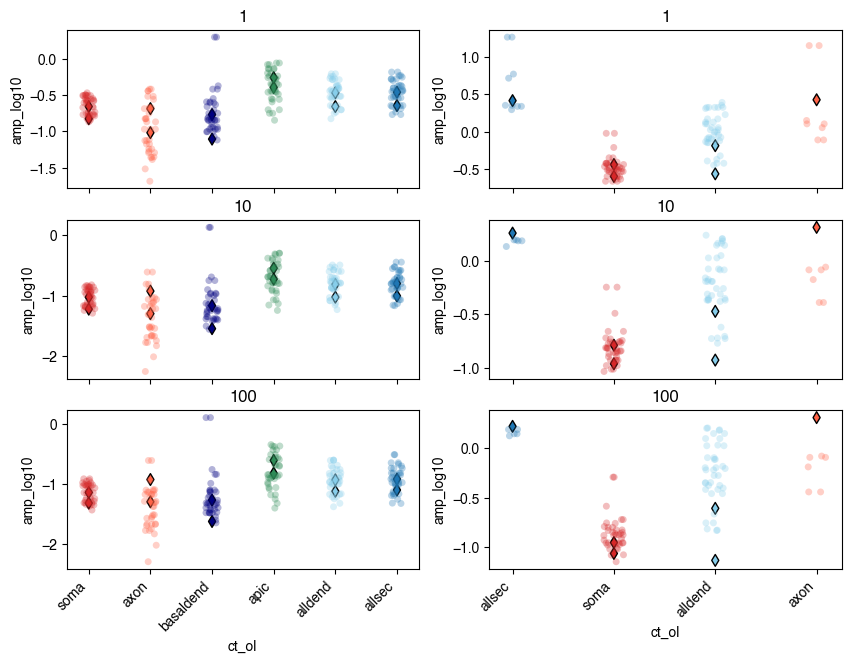

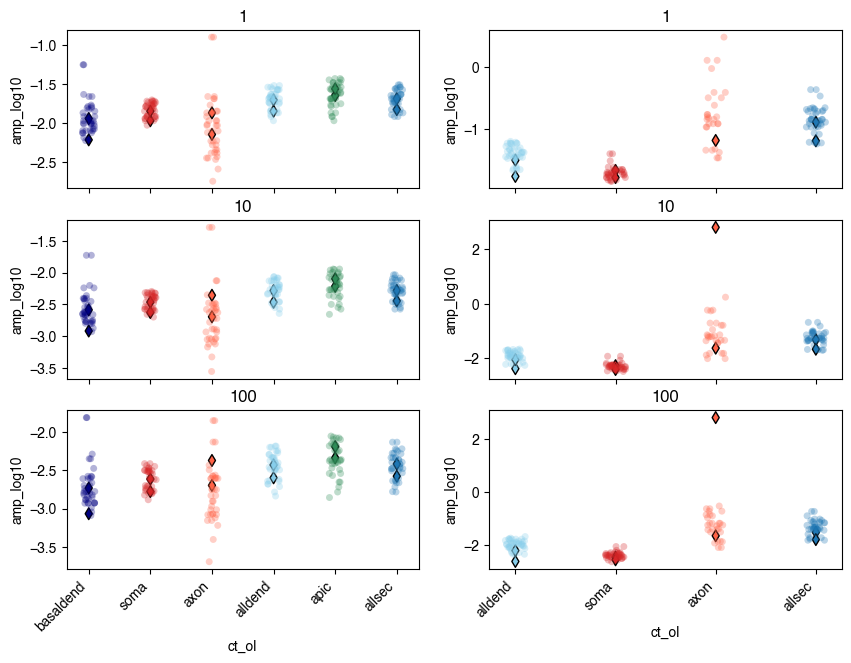

In [7]:
for gmax in [1, 10]:
    fig, axs = plt.subplots(3, 2, figsize=(10, 7), sharex='col')
    for x, axrow in zip(unique_values_columns_master['dur'], axs):
        for mytype, ax in zip(["pyr", 'int'], axrow):
            idx = (master_df['Gmax'] == gmax) & (master_df['dur'] == x) & (
                np.array(master_df['cell_id'].str.contains(mytype)))
            idx1 = idx & (master_df['miglioreModel'] != 'default')
            if any(idx1):
                sns.stripplot(data=master_df[idx1], x='ct_ol', y='amp_log10',
                              hue='opsinlocations', palette=colorkeyval, alpha=0.3, ax=ax)
            plt.draw()
            idx2 = idx & (master_df['miglioreModel'] == 'default')
            sns.scatterplot(data=master_df[idx2], x='ct_ol', y='amp_log10', hue='opsinlocations',
                            marker='d', edgecolor='k', palette=colorkeyval, linewidth=1, ax=ax)
            ax.set_title(x)
            legend = ax.get_legend()
            legend.remove()

    for i in range(2):
        axs[-1, i].set_xticks(axs[-1, i].get_xticks())
        labels = axs[-1, i].get_xticklabels()
        labels = [x.get_text().split('_', 1)[-1] for x in labels]
        axs[-1, i].set_xticklabels(labels, rotation=45, ha='right')
    print()

In [8]:
master_df['ct_ol'].unique()

array(['pyr_alldend', 'pyr_allsec', 'pyr_apic', 'pyr_axon',
       'pyr_basaldend', 'pyr_soma', 'int_axon', 'int_soma', 'int_alldend',
       'int_allsec'], dtype=object)

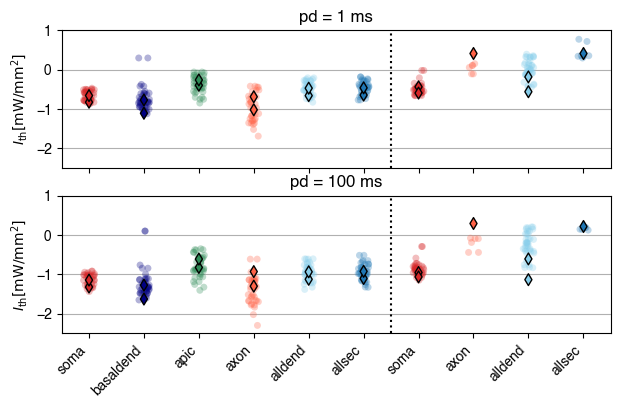

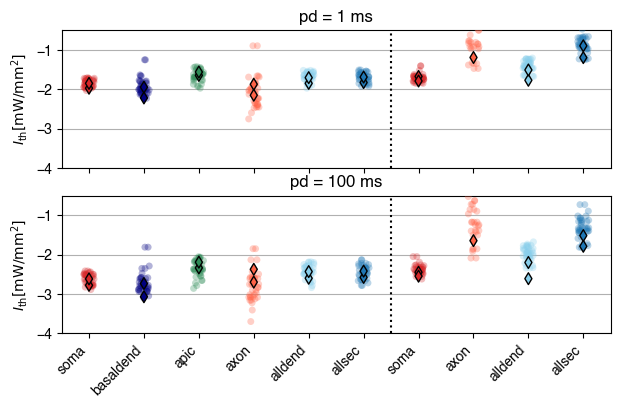

In [9]:

order = ['pyr_soma',  'pyr_basaldend', 'pyr_apic', 'pyr_axon', 'pyr_alldend',
         'pyr_allsec',  'int_soma', 'int_axon', 'int_alldend', 'int_allsec']
for gmax in [1, 10]:
    fig, axs = plt.subplots(2, 1, figsize=(18/2.54, 10/2.54), sharex='col')
    for x, ax in zip(unique_values_columns_master['dur'][::2], axs):
        idx = (master_df['Gmax'] == gmax) & (master_df['dur'] == x)
        idx1 = idx & (master_df['miglioreModel'] != 'default')
        if any(idx1):
            sns.stripplot(data=master_df[idx1], x='ct_ol', y='amp_log10',
                          hue='opsinlocations', palette=colorkeyval, order=order, alpha=0.3, ax=ax)
        plt.draw()
        idx2 = idx & (master_df['miglioreModel'] == 'default')
        sns.stripplot(data=master_df[idx2], x='ct_ol', y='amp_log10', hue='opsinlocations', size=6,
                      marker='d', edgecolor='k', order=order, jitter=False,  palette=colorkeyval, linewidth=1, ax=ax)
        ax.set_title(f"pd = {x} ms")
        legend = ax.get_legend()
        legend.remove()
        ax.axvline(x=5.5, color='k', linestyle=':')
        ax.set_ylabel('$I_\mathrm{th} [\mathrm{mW/mm^2}]$')
        # ax.minorticks_on()
        # ax.tick_params(axis='y', which='minor')
        # ax.tick_params(axis='x', which='minor', bottom=False)
        ax.grid(visible=True, axis='y')
        ax.grid(visible=True, which='minor', axis='y')
        ax.grid(visible=True, which='both', axis='y')

    axs[-1].set_xticks(axs[-1].get_xticks())
    labels = axs[-1].get_xticklabels()
    labels = [x.get_text().split('_', 1)[-1] for x in labels]
    axs[-1].set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('')
    if gmax == 1:
        axs[0].set_ylim([-2.5, 1])
        axs[1].set_ylim([-2.5, 1])
    else:
        axs[0].set_ylim([-4, -0.5])
        axs[1].set_ylim([-4, -0.5])
    fig.savefig(f"miglioreModels{gmax}.svg", dpi=300)
print()

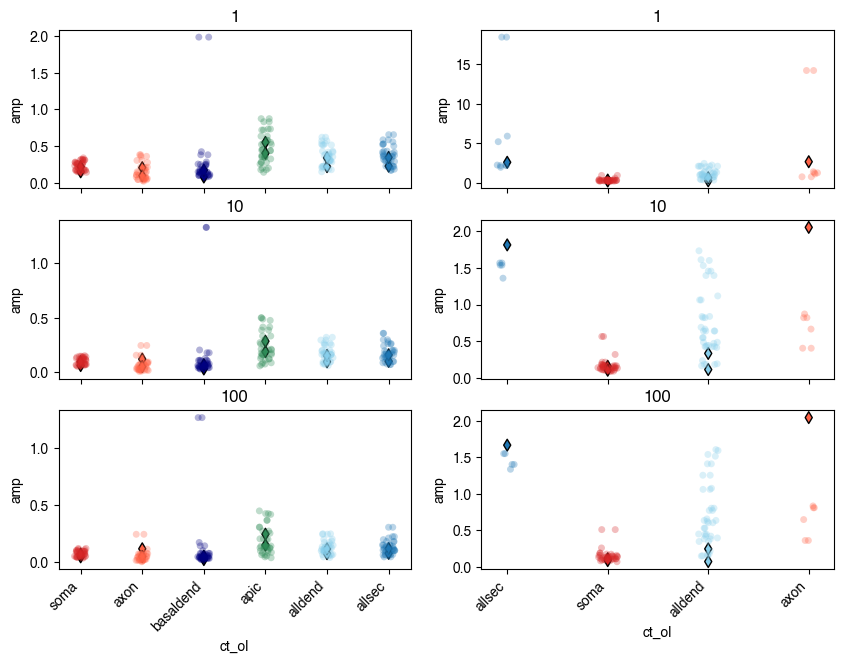

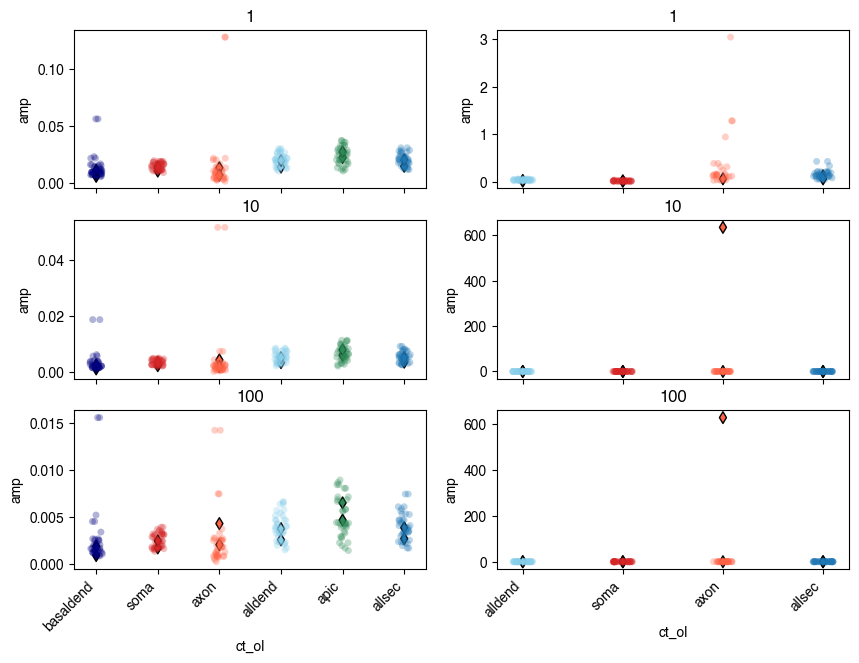

In [10]:

for gmax in [1, 10]:
    fig, axs = plt.subplots(3, 2, figsize=(10, 7), sharex='col')
    for x, axrow in zip(unique_values_columns_master['dur'], axs):
        for mytype, ax in zip(["pyr", 'int'], axrow):
            idx = (master_df['Gmax'] == gmax) & (master_df['dur'] == x) & (
                np.array(master_df['cell_id'].str.contains(mytype)))
            idx1 = idx & (master_df['miglioreModel'] != 'default')
            sns.stripplot(data=master_df[idx1], x='ct_ol', y='amp',
                          hue='opsinlocations', palette=colorkeyval, alpha=0.3, ax=ax)
            idx2 = idx & (master_df['miglioreModel'] == 'default')
            sns.scatterplot(data=master_df[idx2], x='ct_ol', y='amp', hue='opsinlocations',
                            marker='d', edgecolor='k', palette=colorkeyval, linewidth=1, ax=ax)
            ax.set_title(x)
            legend = ax.get_legend()
            legend.remove()
    plt.draw()
    for i in range(2):
        axs[-1, i].set_xticks(axs[-1, i].get_xticks())
        labels = axs[-1, i].get_xticklabels()
        labels = [x.get_text().split('_', 1)[-1] for x in labels]
        axs[-1, i].set_xticklabels(labels, rotation=45, ha='right')
    print()

no normalizer: axon, int, 1
no normalizer: soma, int, 1
no normalizer: alldend, int, 1
no normalizer: allsec, int, 1
no normalizer: soma, int, 1
no normalizer: alldend, int, 1
no normalizer: axon, int, 1
no normalizer: allsec, int, 1
no normalizer: allsec, int, 1
no normalizer: soma, int, 1
no normalizer: alldend, int, 1
no normalizer: axon, int, 1
no normalizer: allsec, int, 1
no normalizer: axon, int, 1
no normalizer: soma, int, 1
no normalizer: alldend, int, 1
no normalizer: allsec, int, 1
no normalizer: axon, int, 1
no normalizer: soma, int, 1
no normalizer: alldend, int, 1
no normalizer: allsec, int, 1
no normalizer: axon, int, 1
no normalizer: soma, int, 1
no normalizer: alldend, int, 1
no normalizer: axon, int, 1
no normalizer: allsec, int, 1
no normalizer: soma, int, 1
no normalizer: alldend, int, 1
no normalizer: axon, int, 1
no normalizer: allsec, int, 1
no normalizer: soma, int, 1
no normalizer: alldend, int, 1
no normalizer: allsec, int, 1
no normalizer: soma, int, 1
no nor

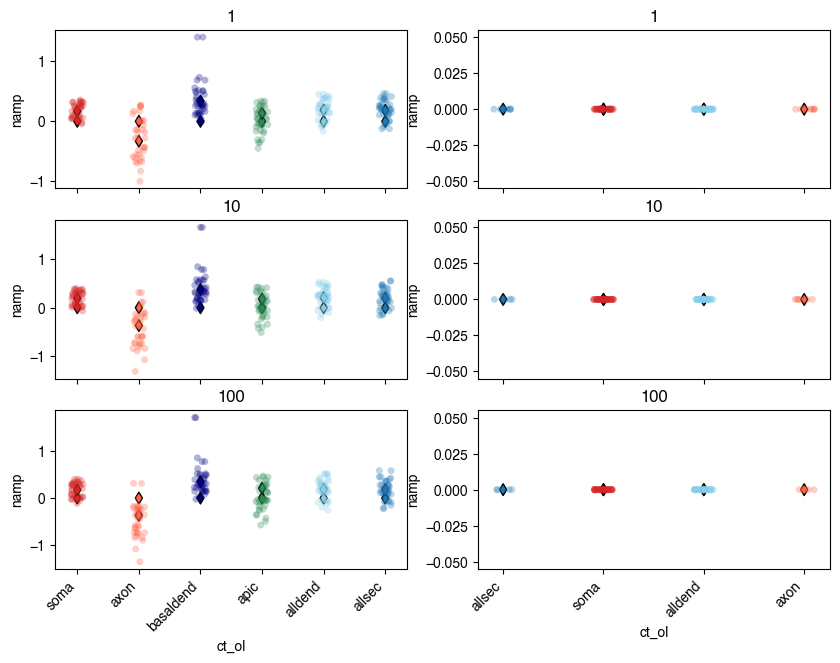

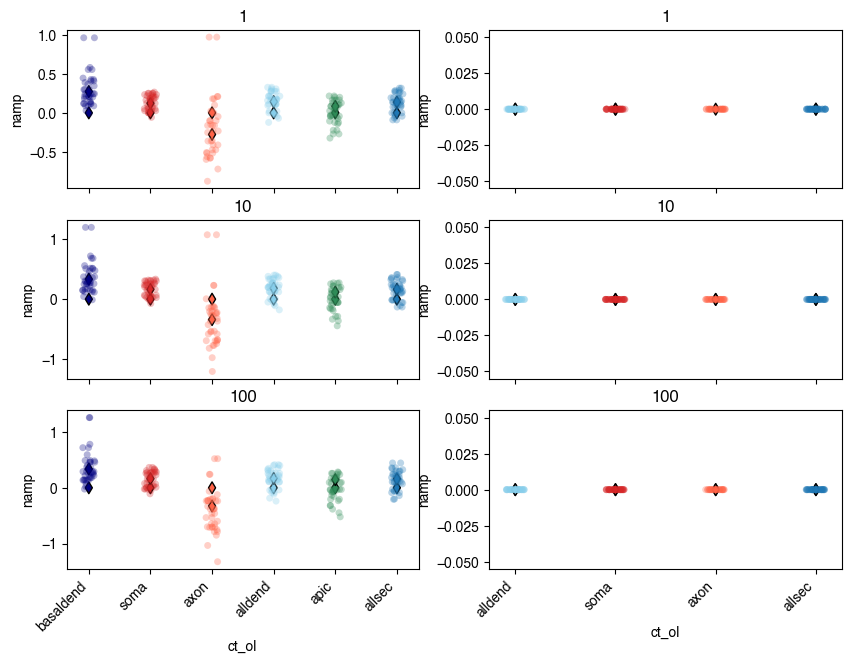

In [11]:
for gmax in [1, 10]:
    fig, axs = plt.subplots(3, 2, figsize=(10, 7), sharex='col')
    for x, axrow in zip(unique_values_columns_master['dur'], axs):
        for mytype, ax in zip(["pyr", 'int'], axrow):
            idx = (master_df['Gmax'] == gmax) & (master_df['dur'] == x) & (
                np.array(master_df['cell_id'].str.contains(mytype)))
            intm_df = master_df[idx].copy()
            idx1 = intm_df['miglioreModel'] != 'default'
            idx2 = intm_df['miglioreModel'] == 'default'
            nidx = intm_df['cell_id'] == 'pyr_0'
            intm_df['namp'] = 0*intm_df['amp']
            for ol in intm_df['opsinlocations']:
                cells_idx = ~nidx & (intm_df['opsinlocations'] == ol)
                normalizer_idx = nidx & (intm_df['opsinlocations'] == ol)
                if any(normalizer_idx):
                    intm_df.loc[cells_idx, 'namp'] = np.log10(
                        intm_df.loc[cells_idx, 'amp']/intm_df.loc[normalizer_idx, 'amp'].to_numpy())
                else:
                    print(f"no normalizer: {ol}, {mytype}, {x}")
            if any(idx1):
                sns.stripplot(data=intm_df[idx1], x='ct_ol', y='namp',
                              hue='opsinlocations', palette=colorkeyval, alpha=0.3, ax=ax)

            sns.scatterplot(data=intm_df[idx2], x='ct_ol', y='namp', hue='opsinlocations',
                            marker='d', edgecolor='k', palette=colorkeyval, linewidth=1, ax=ax)
            ax.set_title(x)
            legend = ax.get_legend()
            legend.remove()
    plt.draw()
    for i in range(2):
        axs[-1, i].set_xticks(axs[-1, i].get_xticks())
        labels = axs[-1, i].get_xticklabels()
        labels = [x.get_text().split('_', 1)[-1] for x in labels]
        axs[-1, i].set_xticklabels(labels, rotation=45, ha='right')
    print()